# Convolutional Autoencoder for Spectral–Spatial Hyperspectral Unmixing

In [1]:
import os
import scipy.io
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from collections import OrderedDict
from tqdm import tqdm
from spectral import *
import numpy as np

## Samson Dataset
* 读取完整图片和标签（暂时无用）
* 将图片和标签随机裁剪成(40,40)，重复num_samples次，生成的结果存放在list中，作为训练样本
* 对于图像数据/255，缩放到[0,1]区间

In [2]:
'''输入图片和label（均为tensor），返回随机剪裁后的结果'''
def rand_crop(image, label, height, width):
    """随机裁剪特征和标签图像"""
    rect = torchvision.transforms.RandomCrop.get_params(
        image, (height, width))
    image = torchvision.transforms.functional.crop(image, *rect)
    label = torchvision.transforms.functional.crop(label, *rect)
    return image, label

In [3]:
class SamsonDataset(torch.utils.data.Dataset):
    
    img_folder = './Data_Matlab/'
    gt_folder = './GroundTruth/'
    training_file = 'samson_1.mat'
    labels_file = 'end3.mat'
    
    def __init__(self, root='./', num_samples=40, crop_size=(40,40)):
        super(SamsonDataset, self).__init__()
        self.root = root
        self.num_samples = num_samples    #生成的(40,40)样本数目
        self.crop_size = crop_size
        
        '''load data'''
        PATH = os.path.join(self.root, self.img_folder, self.training_file)
        PATH_L = os.path.join(self.root, self.gt_folder, self.labels_file)
        train_data = scipy.io.loadmat(PATH)
        labels = scipy.io.loadmat(PATH_L)
        
        '''preprocess'''
        rows = train_data['nRow'].item()   #95
        cols = train_data['nCol'].item()   #95
        bands = train_data['nBand'].item()  #156
        
        train_data = train_data['V'].T   #train image (9025, 156)
        labels = labels['A'].T    # abundance map(9025, 3)
        
        train_data = train_data.reshape(rows,cols,-1)  #(95,95,156)
        labels = labels.reshape(rows,cols,-1)   #(95,95,3)
        assert train_data.shape[-1]==bands,"trian data shape error"
        train_data_tensor = torch.from_numpy(train_data).permute(2,0,1)   #转换成tensor (156,95,95)
        labels_tensor = torch.from_numpy(labels).permute(2,0,1)     #(3,95,95)
        train_data_tensor = self.normalize_data(train_data_tensor)   # image normalization
        
        self.data_list, self.label_list = self.get_croped_data(train_data_tensor, labels_tensor, self.crop_size, self.num_samples)
        
        print(f"create {len(self.data_list)} data")
    
    def normalize_data(self,train_data_tensor):   #normalization
        return train_data_tensor / 255
    
    def get_croped_data(self,train_data_tensor, labels_tensor, crop_size, num_samples):   # create data samples
        data_list, label_list = [], []
        for i in range(num_samples):
            croped_train_data,croped_label = rand_crop(train_data_tensor, labels_tensor, *crop_size)
            data_list.append(croped_train_data)
            label_list.append(croped_label)
            
        return data_list,label_list
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        return self.data_list[idx], self.label_list[idx]

In [4]:
# batch_size = 8
# Samson_Dataset = SamsonDataset(num_samples=40)
# train_iter = torch.utils.data.DataLoader(Samson_Dataset, batch_size=batch_size, shuffle=True)
# for X,y in train_iter:
#     print(X.shape)
#     print(X)
#     print(y.shape)
# #     print(y)
#     plt.imshow(y[0][0].view(1,40,40).permute(1,2,0))
#     break

## CNN autoencoder model

In [5]:
# '''用于最终生成完整abundance map的拼接后处理'''
# class ASC(nn.Module):
#     '''input 4d image(B,C,H,W) apply pixel wise softmax to satisfy ASC(abundance sum-to-one constraint)'''
#     def __init__(self):
#         super(ASC, self).__init__()
        
    
#     def forward(self, input):
#         """Abundances Sum-to-One Constraint"""
#         constrained = torch.div(input, torch.sum(input, dim=1).view(input.shape[0],1,input.shape[2],input.shape[3]))
#         return constrained

In [6]:
class Scale(nn.Module):
    '''scale before softmax'''
    def __init__(self, scale_rate=3.5):
        super(Scale, self).__init__()
        self.scale_rate = scale_rate
        
    def forward(self, input):
        return input * self.scale_rate

In [7]:
class CNNAE(nn.Module):
    def __init__(self, num_bands=156, dropout=0.2, hidden_c=48, num_endmembers=3, f=11, scale_rate=3.5):
        super(CNNAE, self).__init__()
        self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout2d(dropout)
        self.asc = nn.Softmax(dim=1)
        self.scale = Scale(scale_rate)
        self.BN1 = nn.BatchNorm2d(hidden_c)
        self.BN2 = nn.BatchNorm2d(num_endmembers)
        
        self.encoder = nn.Sequential(OrderedDict([
            ('Conv_1', nn.Conv2d(num_bands, hidden_c, kernel_size=3, padding=1, bias=False, padding_mode='reflect')),
            ('activation_1', self.act),
            ('BatchNormalization_1', self.BN1),
            ('Dropout_1',self.dropout),
            ('Conv_2', nn.Conv2d(hidden_c, num_endmembers, kernel_size=1, bias=False, padding_mode='reflect')),
            ('activation_2', self.act),
            ('BatchNormalization_2', self.BN2),
            ('Dropout_2', self.dropout),
            ('Scale', self.scale),
            ('ASC', self.asc)
        ]))
        
        self.decoder = nn.Sequential(OrderedDict([
            ('Conv_3', nn.Conv2d(num_endmembers, num_bands, kernel_size=f, padding=int((f-1)/2), bias=False, padding_mode='reflect'))
        ]))
        
    
    def forward(self, input):
        encode = self.encoder(input)
        decode = self.decoder(encode)
        return encode, decode

In [8]:
def init_weight(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
#     elif isinstance(m, nn.Linear):
#         nn.init.kaiming_uniform_(m.weight.data)
#         nn.init.constant_(m.bias.data, 0)

In [9]:
# a=torch.rand((8,156,40,40))
# model = CNNAE()
# encode,decode = model(a)
# print(encode.shape)
# print(decode.shape)

## SAD loss (the spectral angle distance)

In [10]:
class SAD(nn.Module):
    def __init__(self, batch_size, num_bands=156, eps=1e-6):
        super(SAD, self).__init__()
        self.num_bands = num_bands
        self.batch_size = batch_size
        self.eps = eps
        
    def forward(self, input, target):
        try:
#             torch.nan_to_num(target)
            input_norm = torch.sqrt(torch.bmm(input.view(self.batch_size,1,-1), input.view(self.batch_size,-1,1)))
            target_norm = torch.sqrt(torch.bmm(target.view(self.batch_size,1,-1), target.view(self.batch_size,-1,1)))
            summation = torch.bmm(input.view(self.batch_size,1,-1), target.view(self.batch_size,-1,1))
            
#             print(f"target_min:{target.min()};target_max:{target.max()}")
            if torch.isnan((summation+self.eps) / (input_norm*target_norm+self.eps)).any():
                print(f"input_min:{input.min()};input_max:{input.max()}")
                print(f"input_norm:{input_norm}")
#                 print(f"target_min:{target.min()};target_max:{target.max()}")
                print(f"target_norm:{target_norm}")
                print(f"summation:{summation}")
                print((summation+self.eps) / (input_norm*target_norm+self.eps))
                print(torch.clamp((summation+self.eps) / (input_norm*target_norm+self.eps),min=-1+self.eps ,max=1-self.eps))
                
            angle = torch.arccos( torch.clamp((summation+self.eps) / (input_norm*target_norm+self.eps),min=-1+self.eps ,max=1-self.eps) ) #clamp否则会出现nan
#             angle = torch.arccos( (summation+self.eps) / (input_norm*target_norm+self.eps) )

        except ValueError:
            return 0.0
        
        return angle


In [11]:
# a=torch.rand((8,156,40,40))
# b=torch.rand((8,156,40,40))
# # c = 1-a
# sad = SAD(batch_size=8)
# c = sad(a,a)
# print(c)
# d = c.sum()
# print(d)
# print(torch.acos(torch.Tensor([1.0])))

## Train

In [12]:
def train(model, train_iter, num_epochs, device, criterion, num_samples):
    model.to(device)
    model.train()
    
    for epoch in range(num_epochs):
        print(f'Epoch: {epoch:^5d}/{num_epochs-1:^5d}')
        print("----------------------------------------------")
        total_loss = 0
        
        for i,(X,_) in enumerate(tqdm(train_iter)):
            X = X.to(device).float()
            optimizer.zero_grad()
            _,reconstruction = model(X)
            loss = criterion(X,reconstruction).sum()
#             print(loss)
            with torch.autograd.set_detect_anomaly(True):
                loss.backward()
            optimizer.step()
            
            total_loss += loss
            
        print(f'average loss:{total_loss/num_samples}')

In [793]:
batch_size, num_epochs, num_samples = 32, 150, 320
Samson_Dataset = SamsonDataset(num_samples=num_samples)
train_iter = torch.utils.data.DataLoader(Samson_Dataset, batch_size=batch_size, shuffle=True)

model = CNNAE()
model.apply(init_weight)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

criterion = SAD(batch_size)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0003)

train(model, train_iter, num_epochs, device, criterion, num_samples)


create 320 data
cuda
Epoch:   0  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.97it/s]


average loss:0.8732876181602478
Epoch:   1  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.93it/s]


average loss:0.4823976159095764
Epoch:   2  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25it/s]


average loss:0.3972682058811188
Epoch:   3  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.60it/s]


average loss:0.35896870493888855
Epoch:   4  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.55it/s]


average loss:0.34148991107940674
Epoch:   5  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.34it/s]


average loss:0.3325803875923157
Epoch:   6  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.44it/s]


average loss:0.3282122015953064
Epoch:   7  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25it/s]


average loss:0.3137561082839966
Epoch:   8  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.28it/s]


average loss:0.3099376857280731
Epoch:   9  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.45it/s]


average loss:0.3026141822338104
Epoch:  10  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27it/s]


average loss:0.29832181334495544
Epoch:  11  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03it/s]


average loss:0.29609355330467224
Epoch:  12  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.46it/s]


average loss:0.29736921191215515
Epoch:  13  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.54it/s]


average loss:0.2910081446170807
Epoch:  14  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.84it/s]


average loss:0.2858109176158905
Epoch:  15  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.71it/s]


average loss:0.2836267650127411
Epoch:  16  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.76it/s]


average loss:0.27948224544525146
Epoch:  17  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.94it/s]


average loss:0.2728710174560547
Epoch:  18  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.45it/s]


average loss:0.27222344279289246
Epoch:  19  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.62it/s]


average loss:0.27335938811302185
Epoch:  20  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.56it/s]


average loss:0.27179303765296936
Epoch:  21  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.58it/s]


average loss:0.26933175325393677
Epoch:  22  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.37it/s]


average loss:0.26383671164512634
Epoch:  23  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23it/s]


average loss:0.26176032423973083
Epoch:  24  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.48it/s]


average loss:0.26123401522636414
Epoch:  25  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.52it/s]


average loss:0.2605172097682953
Epoch:  26  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.63it/s]


average loss:0.26033538579940796
Epoch:  27  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.37it/s]


average loss:0.2590596675872803
Epoch:  28  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.42it/s]


average loss:0.26377439498901367
Epoch:  29  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.52it/s]


average loss:0.26033198833465576
Epoch:  30  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.42it/s]


average loss:0.25614628195762634
Epoch:  31  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.48it/s]


average loss:0.25312525033950806
Epoch:  32  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.33it/s]


average loss:0.25465449690818787
Epoch:  33  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.51it/s]


average loss:0.2503988444805145
Epoch:  34  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.31it/s]


average loss:0.24571667611598969
Epoch:  35  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.35it/s]


average loss:0.2495608627796173
Epoch:  36  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.52it/s]


average loss:0.2485368549823761
Epoch:  37  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.42it/s]


average loss:0.2552221417427063
Epoch:  38  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.51it/s]


average loss:0.25445064902305603
Epoch:  39  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.43it/s]


average loss:0.24919076263904572
Epoch:  40  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.45it/s]


average loss:0.23975224792957306
Epoch:  41  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.40it/s]


average loss:0.23965604603290558
Epoch:  42  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.48it/s]


average loss:0.2424505054950714
Epoch:  43  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.50it/s]


average loss:0.24050724506378174
Epoch:  44  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.48it/s]


average loss:0.2387342005968094
Epoch:  45  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25it/s]


average loss:0.2397071123123169
Epoch:  46  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.55it/s]


average loss:0.2360595017671585
Epoch:  47  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.49it/s]


average loss:0.23077407479286194
Epoch:  48  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.50it/s]


average loss:0.23430085182189941
Epoch:  49  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.32it/s]


average loss:0.23142127692699432
Epoch:  50  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.36it/s]


average loss:0.23107099533081055
Epoch:  51  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23it/s]


average loss:0.23860417306423187
Epoch:  52  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.53it/s]


average loss:0.23111672699451447
Epoch:  53  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.42it/s]


average loss:0.22541287541389465
Epoch:  54  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.52it/s]


average loss:0.22671262919902802
Epoch:  55  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20it/s]


average loss:0.22462604939937592
Epoch:  56  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.34it/s]


average loss:0.227814182639122
Epoch:  57  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.53it/s]


average loss:0.2304961234331131
Epoch:  58  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.15it/s]


average loss:0.2244812250137329
Epoch:  59  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24it/s]


average loss:0.22813475131988525
Epoch:  60  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.35it/s]


average loss:0.2247704267501831
Epoch:  61  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.43it/s]


average loss:0.22103969752788544
Epoch:  62  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26it/s]


average loss:0.2212439626455307
Epoch:  63  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.53it/s]


average loss:0.2241584062576294
Epoch:  64  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.41it/s]


average loss:0.21605980396270752
Epoch:  65  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24it/s]


average loss:0.21736614406108856
Epoch:  66  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.36it/s]


average loss:0.21987676620483398
Epoch:  67  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.38it/s]


average loss:0.2163892239332199
Epoch:  68  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.42it/s]


average loss:0.21499310433864594
Epoch:  69  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.53it/s]


average loss:0.21969254314899445
Epoch:  70  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.47it/s]


average loss:0.2154218703508377
Epoch:  71  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19it/s]


average loss:0.21978040039539337
Epoch:  72  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.32it/s]


average loss:0.21680036187171936
Epoch:  73  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.30it/s]


average loss:0.21358858048915863
Epoch:  74  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.38it/s]


average loss:0.21991129219532013
Epoch:  75  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.08it/s]


average loss:0.21100106835365295
Epoch:  76  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.31it/s]


average loss:0.20793865621089935
Epoch:  77  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26it/s]


average loss:0.2138553112745285
Epoch:  78  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.59it/s]


average loss:0.21522915363311768
Epoch:  79  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.55it/s]


average loss:0.21316340565681458
Epoch:  80  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11it/s]


average loss:0.20760519802570343
Epoch:  81  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.32it/s]


average loss:0.20775559544563293
Epoch:  82  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.29it/s]


average loss:0.21112887561321259
Epoch:  83  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27it/s]


average loss:0.20777879655361176
Epoch:  84  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.43it/s]


average loss:0.20584635436534882
Epoch:  85  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.46it/s]


average loss:0.21294239163398743
Epoch:  86  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06it/s]


average loss:0.20680618286132812
Epoch:  87  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.42it/s]


average loss:0.21128161251544952
Epoch:  88  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.31it/s]


average loss:0.2101132720708847
Epoch:  89  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.51it/s]


average loss:0.21178112924098969
Epoch:  90  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.38it/s]


average loss:0.20607736706733704
Epoch:  91  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.35it/s]


average loss:0.20483508706092834
Epoch:  92  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27it/s]


average loss:0.21561014652252197
Epoch:  93  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.54it/s]


average loss:0.20398426055908203
Epoch:  94  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19it/s]


average loss:0.20353277027606964
Epoch:  95  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19it/s]


average loss:0.20376406610012054
Epoch:  96  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.30it/s]


average loss:0.21151737868785858
Epoch:  97  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.11it/s]


average loss:0.21277987957000732
Epoch:  98  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26it/s]


average loss:0.20451048016548157
Epoch:  99  / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.23it/s]


average loss:0.20450735092163086
Epoch:  100 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20it/s]


average loss:0.2053811103105545
Epoch:  101 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.33it/s]


average loss:0.20247144997119904
Epoch:  102 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18it/s]


average loss:0.19886673986911774
Epoch:  103 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.78it/s]


average loss:0.20309798419475555
Epoch:  104 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97it/s]


average loss:0.20298127830028534
Epoch:  105 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.54it/s]


average loss:0.20475411415100098
Epoch:  106 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.67it/s]


average loss:0.198980450630188
Epoch:  107 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.56it/s]


average loss:0.20458482205867767
Epoch:  108 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.80it/s]


average loss:0.19750098884105682
Epoch:  109 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95it/s]


average loss:0.20458777248859406
Epoch:  110 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04it/s]


average loss:0.19788379967212677
Epoch:  111 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.74it/s]


average loss:0.19708502292633057
Epoch:  112 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04it/s]


average loss:0.20214898884296417
Epoch:  113 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.03it/s]


average loss:0.19678401947021484
Epoch:  114 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.73it/s]


average loss:0.19971345365047455
Epoch:  115 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.97it/s]


average loss:0.19889311492443085
Epoch:  116 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.04it/s]


average loss:0.19752167165279388
Epoch:  117 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81it/s]


average loss:0.1970057189464569
Epoch:  118 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.21it/s]


average loss:0.19848565757274628
Epoch:  119 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24it/s]


average loss:0.20427878201007843
Epoch:  120 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06it/s]


average loss:0.19923965632915497
Epoch:  121 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.12it/s]


average loss:0.19897475838661194
Epoch:  122 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.31it/s]


average loss:0.1986495852470398
Epoch:  123 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.29it/s]


average loss:0.19545233249664307
Epoch:  124 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.14it/s]


average loss:0.20200982689857483
Epoch:  125 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.26it/s]


average loss:0.19707922637462616
Epoch:  126 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.43it/s]


average loss:0.19283883273601532
Epoch:  127 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18it/s]


average loss:0.1957678496837616
Epoch:  128 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.36it/s]


average loss:0.19975928962230682
Epoch:  129 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.32it/s]


average loss:0.1971758008003235
Epoch:  130 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25it/s]


average loss:0.18957339227199554
Epoch:  131 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.41it/s]


average loss:0.1990663707256317
Epoch:  132 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.37it/s]


average loss:0.19017478823661804
Epoch:  133 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.48it/s]


average loss:0.19841858744621277
Epoch:  134 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25it/s]


average loss:0.19711731374263763
Epoch:  135 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.54it/s]


average loss:0.19960449635982513
Epoch:  136 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.17it/s]


average loss:0.1956910938024521
Epoch:  137 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.29it/s]


average loss:0.1919008493423462
Epoch:  138 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.20it/s]


average loss:0.19724887609481812
Epoch:  139 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.19it/s]


average loss:0.19128362834453583
Epoch:  140 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.39it/s]


average loss:0.1928325742483139
Epoch:  141 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.29it/s]


average loss:0.19011402130126953
Epoch:  142 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.13it/s]


average loss:0.1917567104101181
Epoch:  143 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25it/s]


average loss:0.19871936738491058
Epoch:  144 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.17it/s]


average loss:0.19565434753894806
Epoch:  145 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.40it/s]


average loss:0.18910343945026398
Epoch:  146 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.41it/s]


average loss:0.18896614015102386
Epoch:  147 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.24it/s]


average loss:0.1954236477613449
Epoch:  148 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.27it/s]


average loss:0.1869993954896927
Epoch:  149 / 149 
----------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.35it/s]

average loss:0.1938919574022293


In [794]:
'''save model'''
torch.save(model.state_dict(), './model/CNNAEU.pth')

In [795]:
for name, param in model.named_parameters():
    print(torch.isnan(param).any())
    
print(model.decoder.Conv_3.weight.min(),model.decoder.Conv_3.weight.max())


tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(-0.3254, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4445, device='cuda:0', grad_fn=<MaxBackward1>)


## prediction of abundance map


In [24]:
model = CNNAE()
model.load_state_dict(torch.load('./model/CNNAEU_7.pth'))
model.to('cpu')
model.eval()
'''读取输入图片'''
img_folder = './Data_Matlab/'
training_file = 'samson_1.mat'
PATH = os.path.join(img_folder, training_file)
train_data = scipy.io.loadmat(PATH)
image = train_data['V'].T.reshape(95,95,156)   #原图像(95,95,156)
image_tensor = torch.from_numpy(image)
image_tensor = image_tensor.permute(2,0,1).contiguous().view(1,156,95,95)

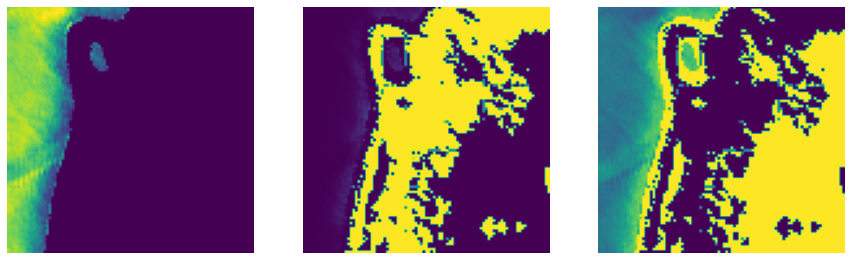

In [26]:
'''确定crop时的左上角坐标'''
point_list = [0,30,55]
crop_point_list = []    #crop图片起始点
for item in point_list:
    for tmp in point_list:
        crop_point_list.append((item,tmp))
        
# print(crop_point_list)
crop_size = (40,40)
predict_abundance = torch.zeros((3,95,95))

'''crop 分别预测 并将结果拼接'''
for crop_point in crop_point_list:
    croped_image = torchvision.transforms.functional.crop(image_tensor,*crop_point,*crop_size)
    encode,_ = model(croped_image.float())
    (x,y) = crop_point
    predict_abundance[:,x:x+40,y:y+40] += encode[0]
    
#     if torch.isnan(encode).any():
#         print("nan in encode")
#         print(encode)
    
# if torch.isnan(predict_abundance).any():
#     print("nan in predict abundance")
    

predict_abundance = predict_abundance / predict_abundance.sum(dim=0).view(1,95,95)  #ASC 将重叠区域归一化

'''visualization'''
fig = plt.figure(figsize=(15, 5))
for i in range(3):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(predict_abundance[i].detach().T)
    plt.axis('off')
plt.show()

## Performance visuliazation

### referece abundance and endmembers

In [106]:
'''get refrence abundance and endmembers'''
img_folder = './Data_Matlab/'
gt_folder = './GroundTruth/'
training_file = 'samson_1.mat'
labels_file = 'end3.mat'

PATH = os.path.join(img_folder, training_file)
PATH_L = os.path.join(gt_folder, labels_file)
train_data = scipy.io.loadmat(PATH)
labels = scipy.io.loadmat(PATH_L)

image = train_data['V'].T.reshape(95,95,156)   #原图像(95,95,156)
image = np.transpose(image, (1, 0, 2))
abundance = labels['A']   # (3,95*95)
endmembers = labels['M'].T  #(3,156)

# rows, columns = 5, 5
# fig = plt.figure(figsize=(10, 10))
# for i in range(25):
#     fig.add_subplot(rows, columns, i+1)
#     plt.imshow(image[i].reshape(95,95,1))
#     plt.axis('off')
#     plt.title(f"channel {i}")

Raster Displays:https://www.spectralpython.net/graphics.html

(95, 95, 156)
ImageView object:
  Display bands       :  [0, 78.0, 155]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 0.09843081312410841]
    G: [0.011412268188302425, 0.38659058487874465]
    B: [0.004992867332382311, 0.9144079885877318]



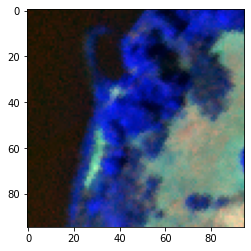

In [107]:
'''image'''
print(image.shape)
view = imshow(image)
print(view)

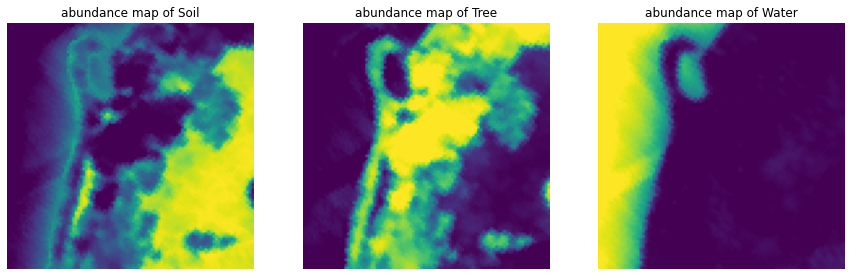

In [108]:
'''display reference abundace map'''
rows, columns = 1, 3
endmember_list = ['Soil', 'Tree', 'Water']
fig = plt.figure(figsize=(15, 5))
for i in range(3):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(abundance[i].reshape(95,95).T)
    plt.axis('off')
    plt.title(f"abundance map of {endmember_list[i]}")

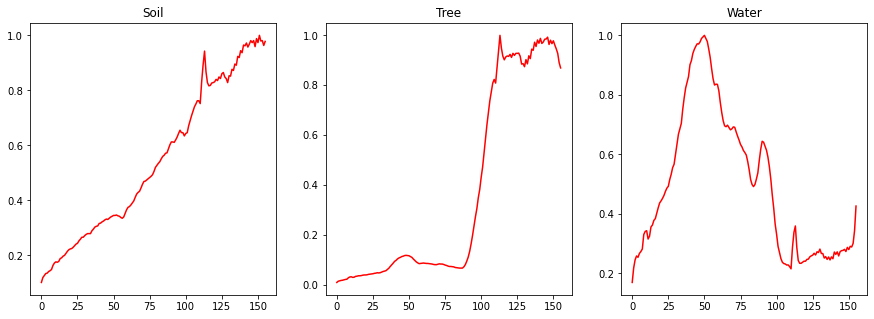

In [30]:
# print(endmembers.shape)
# bands = np.arange(0,156,1)
# print(bands.shape)
# plt.plot(bands, endmembers[0])
# print(endmembers[0].shape)
# print(type(endmembers[0]))

'''display reference endmembers'''
rows, columns = 1, 3
bands = np.arange(0,156,1)
endmember_list = ['Soil', 'Tree', 'Water']
fig = plt.figure(figsize=(15, 5))
for i in range(3):
    fig.add_subplot(rows, columns, i+1)
    plt.plot(bands, endmembers[i] / endmembers[i].max() ,'r')
    plt.title(f"{endmember_list[i]}")

### endmembers extraction result

torch.Size([156, 3, 11, 11])


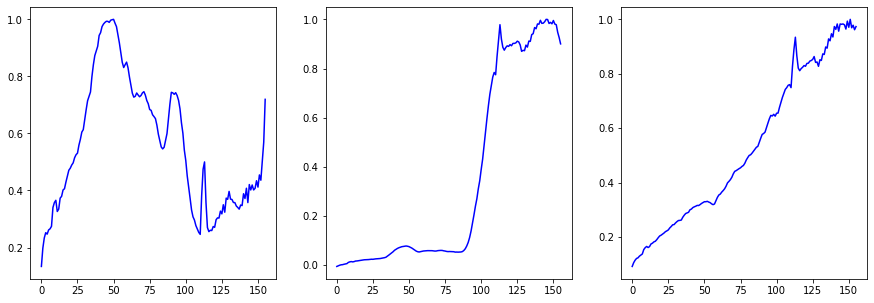

In [31]:
print(model.decoder.Conv_3.weight.shape)
extract_endmembers = model.decoder.Conv_3.weight.permute(1,2,3,0)

fig = plt.figure(figsize=(15, 5))
for i in range(3):
    tmp = extract_endmembers[i].reshape((-1,156)).sum(dim=0)
    tmp = tmp / tmp.max()
    fig.add_subplot(1, 3, i+1)
    plt.plot(bands, np.array(tmp.cpu().detach()), 'b')

### endmember comparison

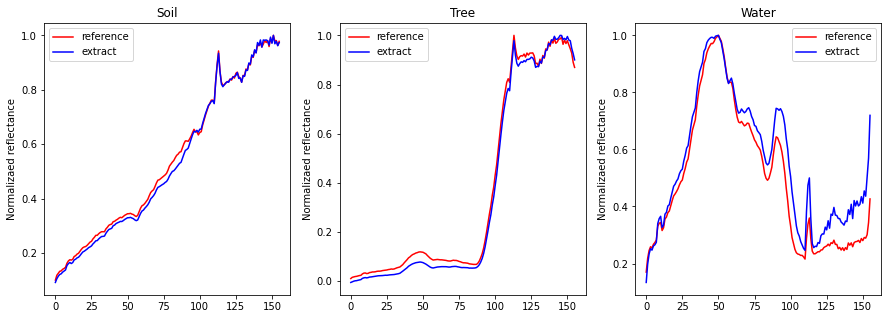

In [78]:
rows, columns = 1, 3
order = [2,1,0]    #手动匹配类型
endmember_list = ['Soil', 'Tree', 'Water']
extract_endmembers_list = [] #保存ordered extract endmembers

fig = plt.figure(figsize=(15, 5))

for i in range(3):
    fig.add_subplot(rows, columns, i+1)
    plt.plot(bands, endmembers[i] / endmembers[i].max(), 'r', label='reference')
    tmp = extract_endmembers[order[i]].reshape((-1,156)).sum(dim=0)
    tmp = tmp / tmp.max()
    extract_endmembers_list.append(tmp)
    plt.plot(bands, np.array(extract_endmembers_list[i].cpu().detach()), 'b', label='extract')
    plt.legend()
    plt.ylabel("Normalizaed reflectance")
    plt.title(endmember_list[i])

plt.show()

abundance map comparison

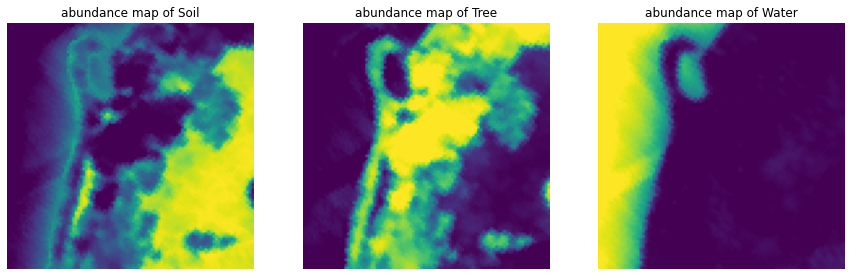

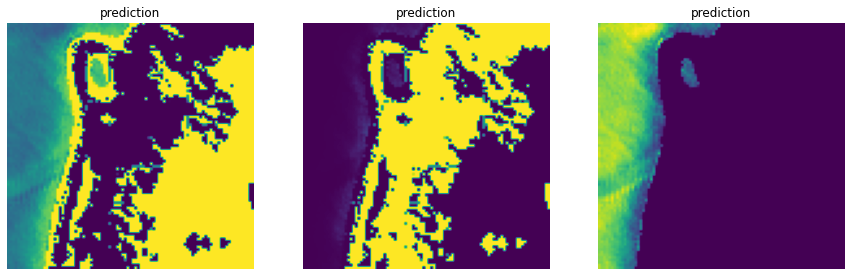

In [49]:
rows, columns = 1, 3
endmember_list = ['Soil', 'Tree', 'Water']
fig = plt.figure(figsize=(15, 5))
for i in range(3):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(abundance[i].reshape(95,95).T)
    plt.axis('off')
    plt.title(f"abundance map of {endmember_list[i]}")
    
    
fig = plt.figure(figsize=(15, 5))
for i in range(3):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(predict_abundance[order[i]].detach().T)
    plt.axis('off')
    plt.title(f"prediction")

## Performance evaluation


In [131]:
'''endmembers comparison'''
num_endmembers = 3

sad = 0
for i in range(num_endmembers):
    m = torch.from_numpy(endmembers[i] / endmembers[i].max() ).float()
    n = extract_endmembers_list[i].float()
    m_norm = torch.sqrt(torch.bmm(m.view(1,1,-1), m.view(1,-1,1)))
    n_norm = torch.sqrt(torch.bmm(n.view(1,1,-1), n.view(1,-1,1)))
    summation = torch.bmm(m.view(1,1,-1), n.view(1,-1,1))
    angle = torch.arccos( summation / (m_norm*n_norm) )
    print(f"angle of {endmember_list[i]}:{angle.item()}")
    sad += angle

msad = sad / num_endmembers
print(f"msad:{msad.item()}")

angle of Soil:0.025727154687047005
angle of Tree:0.046676620841026306
angle of Water:0.11302526295185089
msad:0.06180967763066292


In [119]:

print(abundance.shape)
print(predict_abundance.shape)

sum_square = 0
for i in range(num_endmembers):
    m = torch.from_numpy(abundance[i])
    n = predict_abundance[order[i]].view(9025)
    square = torch.sum(torch.square(n-m))
    print(f"sum of square of {endmember_list[i]} :{square.item()}")
    sum_square += square.item()
    
mse = sum_square / num_endmembers    
print(f"mse :{mse}")

(3, 9025)
torch.Size([3, 95, 95])
sum of square of Soil :965.2618817250168
sum of square of Tree :531.1082583732455
sum of square of Water :424.46746451485603
mse :640.2792015377062
